In [1]:
import pickle
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def change_features(df):
    df['AVG_returns'] = (df['AVG_returns'] + 1) ** 252 - 1
    df['Risk'] = (df['Risk'] + 1) ** np.sqrt(252) - 1
    df['Alpha'] = df['Alpha'].round(4)
    df['Drawdown'] = -df['Drawdown']
    return df 

In [3]:
dict_category2emb = {
    'topological features' : [
        'PersImage_2',
        'PersLandscape_1',
        'PersImage_1',
        'PersLandscape_2',
        'topo_features',
        'PersImage_2_new',
        'PersLandscape_1_new',
        'PersImage_1_new',
        'PersLandscape_2_new',
        'topo_features_new',                      
      ],
    
    'Dimensionality reduction' : ['umap', 'pca', 'fastica', 'tnse'],
    
    'transformers' : [ 
        'transformer_embds1',
        'transformer_embds2',
        'transformer_embds3',
        'transformer_embds4',
        'transformer_embds5',
    ],
    
    'autoencoders' : [ 
        'autoencoder_conv',
        'autoencoder_lstm',
        'autoencoder_mlp',
    ],
    
    #'baselines' : ['sp500', 'sectors'],
    'index': ['sp500'],
    'ecomonic sectors': ['sectors'],
    
    'classical features' : [ 'tsfresh', 'table_finance_features'],
    
#     'time_clustering' : ['KShape',
#  'MSTcorr',
#  'TimeSeriesKMeans'],
    
    'NN embedding' : ['ts2vec', 'signal2vec_embds']
}

dict_emb2cat = {method:categ for categ, list_methods in dict_category2emb.items() for method in list_methods }

# Data loading

In [4]:
fin_results_2012 = pd.read_csv('results/usa_2012_s2v/financial_metric_False.csv', index_col=0)
fin_results_2015 = pd.read_csv('results/usa_2015_s2v/financial_metric_False.csv', index_col=0)
fin_results_2018 = pd.read_csv('results/usa_2018_s2v/financial_metric_False.csv', index_col=0)

clust_results_2012 = pd.read_csv('results/usa_2012_s2v/clust_metric_False.csv', index_col=0)
clust_results_2015 = pd.read_csv('results/usa_2015_s2v/clust_metric_False.csv', index_col=0)
clust_results_2018 = pd.read_csv('results/usa_2018_s2v/clust_metric_False.csv', index_col=0)
fin_results_2012.head()

,AVG_returns,Risk,Beta,Alpha,Sharpe,VaR,Drawdown,Recovery,clust_model,emb_model
port,0.000517,0.016028,0.329642,0.000345,0.024955,-0.026447,-37.243770,385.0,KMeans,ts2vec
port,0.001062,0.014736,0.384230,0.000881,0.064101,-0.024314,-27.391429,259.0,Agg,ts2vec
port,0.000656,0.007743,0.752471,0.000414,0.069636,-0.012776,-11.716343,185.0,KMeans,PersImage_2
port,0.000659,0.008137,0.736411,0.000420,0.066596,-0.013426,-11.172857,183.0,Agg,PersImage_2
port,0.000633,0.015816,0.339472,0.000459,0.032596,-0.026096,-38.037391,385.0,KMeans,PersLandscape_1


In [5]:
def load_fin_clust(exp_name):
    dict_data = {
        "finance":pd.read_csv(f'results/{exp_name}_s2v/financial_metric_False.csv', index_col=0),
        "clustering":pd.read_csv(f'results/{exp_name}_s2v/clust_metric_False.csv', index_col=0)
    }
    return dict_data


In [6]:
experiments = ['usa_2012', 'usa_2015', 'usa_2018']
dict_results = {exp:load_fin_clust(exp) for exp in experiments}

In [7]:
def build_entire_table(fin_results, clust_results, dict_emb2cat, sort_metric='Risk'):
    fin_results = change_features(fin_results)

    df_to_rebuild = fin_results
    df_to_rebuild = pd.merge(clust_results.drop(columns=['clust_model']), df_to_rebuild, on='emb_model', how='outer')

    df_best_clustering = df_to_rebuild.sort_values([sort_metric], ascending=False)
    df_best_clustering = df_best_clustering.groupby('emb_model', as_index=False, sort=True).first()

    df_best_clustering['category'] = df_best_clustering['emb_model'].map(dict_emb2cat)
    return df_best_clustering.sort_values(sort_metric)

In [8]:
dict_results_selected = {exp:build_entire_table(
        dict_results[exp]['finance'], 
        dict_results[exp]['clustering'], 
        dict_emb2cat
        ) 
    for exp in experiments
}

# all experiments analysis

In [9]:
all_experiments = pd.DataFrame([])

for exp_name, exp_data in dict_results_selected.items():
    exp_data['exp_name'] = exp_name
    
    all_experiments = pd.concat([all_experiments, exp_data])
    
print(all_experiments.shape)
all_experiments.head()

(81, 16)


,emb_model,DB,HC,Sil,hom,AVG_returns,Risk,Beta,Alpha,Sharpe,VaR,Drawdown,Recovery,clust_model,category,exp_name
2,PersImage_2,1.724300,61.553752,0.145029,0.099462,0.180643,0.137287,0.736411,0.0004,0.066596,-0.013426,11.172857,183.0,Agg,topological features,usa_2012
15,sp500,NaN,NaN,NaN,NaN,0.073929,0.142009,1.000000,0.0000,0.019734,-0.013860,14.183248,253.0,sp500,index,usa_2012
1,PersImage_1_new,2.000960,39.930084,0.090499,0.084176,0.321024,0.143070,0.771189,0.0009,0.116810,-0.013957,9.653751,62.0,Agg,topological features,usa_2012
0,PersImage_1,2.113002,38.591573,0.112135,0.085452,0.230194,0.143126,0.790175,0.0006,0.083330,-0.013962,11.145127,128.0,Agg,topological features,usa_2012
3,PersImage_2_new,2.032880,48.452407,0.093876,0.092620,0.274011,0.153945,0.717191,0.0007,0.093166,-0.014950,10.573384,82.0,Agg,topological features,usa_2012


In [10]:
features_to_drop = ['DB', 'HC', 'Sil', 'hom', 'Beta', 'Alpha', 
                    'AVG_returns', 'VaR', 'Drawdown', 'Recovery']

emb_to_drop = ['PersImage_2',
        'PersLandscape_1',
        'PersImage_1',
        'PersLandscape_2',
        'topo_features',]

all_experiments = all_experiments.query('emb_model not in @emb_to_drop')
all_experiments_dropped = all_experiments.drop(features_to_drop, axis=1)

all_experiments_dropped.head()

,emb_model,Risk,Sharpe,clust_model,category,exp_name
15,sp500,0.142009,0.019734,sp500,index,usa_2012
1,PersImage_1_new,0.143070,0.116810,Agg,topological features,usa_2012
3,PersImage_2_new,0.153945,0.093166,Agg,topological features,usa_2012
16,table_finance_features,0.185312,0.084022,KMeans,classical features,usa_2012
14,signal2vec_embds,0.201571,0.070744,Agg,NN embedding,usa_2012


In [11]:
all_experiments_dropped[all_experiments_dropped['category'] == 'transformers'].sort_values('Risk').groupby('exp_name').first()

,emb_model,Risk,Sharpe,clust_model,category
exp_name,,,,,
usa_2012,transformer_embds5,0.211621,0.076999,KMeans,transformers
usa_2015,transformer_embds5,0.160075,0.158944,Agg,transformers
usa_2018,transformer_embds2,0.390733,0.068911,KMeans,transformers


In [12]:
all_exp_melt = pd.melt(all_experiments_dropped, id_vars=['exp_name', 'category', 'emb_model', 'clust_model'], 
        value_vars=['Risk', 'Sharpe'], var_name='metric', value_name='value')

all_exp_pivot = all_exp_melt.pivot(index='emb_model', columns=['exp_name', 'metric'], values=['value'])
all_exp_pivot.columns = all_exp_pivot.columns.droplevel()
all_exp_pivot = all_exp_pivot.sort_index(axis=1, level=0)
all_exp_pivot.sort_values([('usa_2018', 'Risk')], inplace=True)

all_exp_pivot

exp_name                usa_2012            usa_2015            usa_2018  \
metric                      Risk    Sharpe      Risk    Sharpe      Risk   
emb_model                                                                  
PersImage_1_new         0.143070  0.116810  0.133805  0.071600  0.277984   
sp500                   0.142009  0.019734  0.136343  0.043638  0.289158   
PersImage_2_new         0.153945  0.093166  0.147485  0.136218  0.304708   
fastica                 0.279785  0.044366  0.225570  0.078007  0.361338   
pca                     0.279785  0.044366  0.225570  0.078007  0.382380   
topo_features_new       0.245804  0.056592  0.258605  0.156541  0.385058   
ts2vec                  0.287141  0.024955  0.290068  0.098511  0.390234   
transformer_embds2      0.211621  0.076999  0.169785  0.147098  0.390733   
table_finance_features  0.185312  0.084022  0.176772  0.132535  0.392020   
transformer_embds5      0.211621  0.076999  0.160075  0.158944  0.393402   
autoencoder_lstm        0.237643  0.065529  0.219016  0.121365  0.399237   
tsfresh                 0.267469  0.018736  0.243374  0.113466  0.403770   
PersLandscape_1_new     0.294995  0.057674  0.297452  0.140461  0.405468   
transformer_embds3      0.214303  0.081541  0.169452  0.148898  0.407732   
sectors                 0.204896  0.079542  0.166120  0.135522  0.415533   
transformer_embds4      0.236646  0.042340  0.254810  0.133101  0.419380   
transformer_embds1      0.280571  0.046580  0.236600  0.122942  0.419430   
signal2vec_embds        0.201571  0.070744  0.178986  0.080951  0.422718   
umap                    0.220492  0.075281  0.192902  0.110317  0.425462   
autoencoder_conv        0.316566  0.043027  0.205836  0.143847  0.441784   
PersLandscape_2_new     0.241368  0.079673  0.253942  0.154512  0.442155   
autoencoder_mlp         0.297101  0.040065  0.240412  0.113466  0.450260   

exp_name                          
metric                    Sharpe  
emb_model                         
PersImage_1_new         0.030397  
sp500                   0.014858  
PersImage_2_new         0.038479  
fastica                 0.037374  
pca                     0.025618  
topo_features_new       0.064130  
ts2vec                  0.072554  
transformer_embds2      0.068911  
table_finance_features  0.051444  
transformer_embds5      0.066072  
autoencoder_lstm        0.067996  
tsfresh                 0.061094  
PersLandscape_1_new     0.059948  
transformer_embds3      0.059415  
sectors                 0.042644  
transformer_embds4      0.022160  
transformer_embds1      0.027812  
signal2vec_embds        0.039925  
umap                    0.034040  
autoencoder_conv        0.041836  
PersLandscape_2_new     0.091084  
autoencoder_mlp         0.055189

## clustering

In [13]:
save = ['signal2vec_embds', 'PersImage_1_new', 'fastica', 'autoencoder_lstm', 
        'table_finance_features', 'sectors', 'transformer_embds5']
all_experiments_selected = all_experiments.query('emb_model in @save')

features_to_drop = ['DB', 'hom', 'Beta', 'Alpha', 'Sharpe',
                    'AVG_returns', 'VaR', 'Drawdown', 'Recovery']
all_experiments_dropped_clust = all_experiments_selected.drop(features_to_drop, axis=1)

all_experiments_dropped_clust = all_experiments_dropped_clust.sort_values(['Risk'], ascending=True)
all_experiments_gr = all_experiments_dropped_clust.groupby(['exp_name', 'category'], as_index=False, sort=True).first()

all_exp_melt = pd.melt(all_experiments_gr, id_vars=['exp_name', 'category', 'emb_model', 'clust_model'], 
        value_vars=['Risk', 'HC', 'Sil'], var_name='metric', value_name='value')

all_exp_pivot = all_exp_melt.pivot(index=['category', 'emb_model'], columns=['exp_name', 'metric'], values=['value'])
all_exp_pivot.columns = all_exp_pivot.columns.droplevel()
all_exp_pivot = all_exp_pivot.sort_index(axis=1, level=0)
all_exp_pivot.sort_values([('usa_2018', 'Risk')], inplace=True)
all_exp_pivot = all_exp_pivot.drop(['Risk'], axis=1, level=1)

all_exp_pivot = all_exp_pivot.apply(lambda x: round(x, 4))
all_exp_pivot = all_exp_pivot.astype('str')


all_exp_pivot.to_excel('results/tables/clustering.xlsx')

all_exp_pivot

exp_name                                         usa_2012           usa_2015  \
metric                                                 HC      Sil        HC   
category                 emb_model                                             
topological features     PersImage_1_new          39.9301   0.0905   32.7811   
Dimensionality reduction fastica                   3.4451   0.0169    3.4608   
classical features       table_finance_features   76.2371   0.1596  111.7061   
transformers             transformer_embds5      183.1355   0.3021  142.3257   
autoencoders             autoencoder_lstm        239.5721   0.2497  272.4948   
ecomonic sectors         sectors                   7.3799  -0.0299    9.0478   
NN embedding             signal2vec_embds        351.7468   0.2714    280.67   

exp_name                                                  usa_2018           
metric                                               Sil        HC      Sil  
category                 emb_model                                           
topological features     PersImage_1_new          0.0768   35.5266   0.0008  
Dimensionality reduction fastica                  0.0867    3.6449  -0.0679  
classical features       table_finance_features    0.194  127.9292   0.2268  
transformers             transformer_embds5       0.2899  146.1349   0.2773  
autoencoders             autoencoder_lstm         0.3166  299.7216   0.2841  
ecomonic sectors         sectors                 -0.0243   11.0322  -0.0097  
NN embedding             signal2vec_embds         0.2884  320.6968   0.2579

## category results

In [14]:
save = ['signal2vec_embds', 'PersImage_1_new', 'fastica', 'autoencoder_lstm', 'table_finance_features', 'sp500', 'sectors', 'transformer_embds5']
all_experiments_selected = all_experiments_dropped.query('emb_model in @save')
all_experiments_selected = all_experiments_selected.sort_values(['Risk'], ascending=True)
all_experiments_gr = all_experiments_selected.groupby(['exp_name', 'category'], as_index=False, sort=True).first()

all_exp_melt = pd.melt(all_experiments_gr, id_vars=['exp_name', 'category', 'emb_model', 'clust_model'], 
        value_vars=['Risk', 'Sharpe'], var_name='metric', value_name='value')

all_exp_pivot = all_exp_melt.pivot(index=['category', 'emb_model'], columns=['exp_name', 'metric'], values=['value'])
all_exp_pivot.columns = all_exp_pivot.columns.droplevel()
all_exp_pivot = all_exp_pivot.sort_index(axis=1, level=0)
all_exp_pivot.sort_values([('usa_2018', 'Risk')], inplace=True)
all_exp_pivot = all_exp_pivot.apply(lambda x: round(x, 4))
all_exp_pivot = all_exp_pivot.astype('str')


all_exp_pivot.to_excel('results/tables/categories.xlsx')

all_exp_pivot


exp_name                                        usa_2012         usa_2015  \
metric                                              Risk  Sharpe     Risk   
category                 emb_model                                          
topological features     PersImage_1_new          0.1431  0.1168   0.1338   
index                    sp500                     0.142  0.0197   0.1363   
Dimensionality reduction fastica                  0.2798  0.0444   0.2256   
classical features       table_finance_features   0.1853   0.084   0.1768   
transformers             transformer_embds5       0.2116   0.077   0.1601   
autoencoders             autoencoder_lstm         0.2376  0.0655    0.219   
ecomonic sectors         sectors                  0.2049  0.0795   0.1661   
NN embedding             signal2vec_embds         0.2016  0.0707    0.179   

exp_name                                                usa_2018          
metric                                           Sharpe     Risk  Sharpe  
category                 emb_model                                        
topological features     PersImage_1_new         0.0716    0.278  0.0304  
index                    sp500                   0.0436   0.2892  0.0149  
Dimensionality reduction fastica                  0.078   0.3613  0.0374  
classical features       table_finance_features  0.1325    0.392  0.0514  
transformers             transformer_embds5      0.1589   0.3934  0.0661  
autoencoders             autoencoder_lstm        0.1214   0.3992   0.068  
ecomonic sectors         sectors                 0.1355   0.4155  0.0426  
NN embedding             signal2vec_embds         0.081   0.4227  0.0399

## only topological

In [15]:
save_categories = ['topological features', 'index', 'ecomonic sectors']
all_experiments_selected = all_experiments_dropped.query('category in @save_categories')

all_exp_melt = pd.melt(all_experiments_selected, id_vars=['exp_name', 'category', 'emb_model', 'clust_model'], 
        value_vars=['Risk', 'Sharpe'], var_name='metric', value_name='value')

all_exp_pivot = all_exp_melt.pivot(index='emb_model', columns=['exp_name', 'metric'], values=['value'])
all_exp_pivot.columns = all_exp_pivot.columns.droplevel()
all_exp_pivot = all_exp_pivot.sort_index(axis=1, level=0)
all_exp_pivot.sort_values([('usa_2018', 'Risk')], inplace=True)
dict_rename = {'sp500':'index', 'sectors': 'ecomonic sectors '}
all_exp_pivot.index = [dict_rename[cat_name] if cat_name in dict_rename else cat_name
                       for cat_name in all_exp_pivot.index]
all_exp_pivot = all_exp_pivot.apply(lambda x: round(x, 4))
all_exp_pivot = all_exp_pivot.astype('str')

all_exp_pivot.to_excel('results/tables/topological.xlsx')

all_exp_pivot

exp_name            usa_2012         usa_2015         usa_2018        
metric                  Risk  Sharpe     Risk  Sharpe     Risk  Sharpe
PersImage_1_new       0.1431  0.1168   0.1338  0.0716    0.278  0.0304
index                  0.142  0.0197   0.1363  0.0436   0.2892  0.0149
PersImage_2_new       0.1539  0.0932   0.1475  0.1362   0.3047  0.0385
topo_features_new     0.2458  0.0566   0.2586  0.1565   0.3851  0.0641
PersLandscape_1_new    0.295  0.0577   0.2975  0.1405   0.4055  0.0599
ecomonic sectors      0.2049  0.0795   0.1661  0.1355   0.4155  0.0426
PersLandscape_2_new   0.2414  0.0797   0.2539  0.1545   0.4422  0.0911

# Plot portfolios

In [16]:
exp_name = 'usa_2015'
postfix = 's2v'
exp_name_full = f'{exp_name}_{postfix}'

df_market = pd.read_csv(f'data/data/{exp_name}/ticker_data_Market.csv', index_col=0)
df_market.index = pd.to_datetime(df_market.index)
df_market = df_market.pct_change()
df_market

,^GSPC
Date,
2015-01-02,NaN
2015-01-05,-0.018278
2015-01-06,-0.008893
2015-01-07,0.011630
2015-01-08,0.017888
...,...
2019-12-24,-0.000195
2019-12-26,0.005128
2019-12-27,0.000034


In [17]:
with open(f'results/{exp_name_full}/metrics_table_False.pickle', 'rb') as f:
    dict_port_methods = pickle.load(f)
    
sorted(dict_port_methods.keys())

['PersImage_1',
 'PersImage_1_new',
 'PersImage_2',
 'PersImage_2_new',
 'PersLandscape_1',
 'PersLandscape_1_new',
 'PersLandscape_2',
 'PersLandscape_2_new',
 'autoencoder_conv',
 'autoencoder_lstm',
 'autoencoder_mlp',
 'fastica',
 'pca',
 'sectors',
 'signal2vec_embds',
 'table_finance_features',
 'topo_features',
 'topo_features_new',
 'transformer_embds1',
 'transformer_embds2',
 'transformer_embds3',
 'transformer_embds4',
 'transformer_embds5',
 'ts2vec',
 'tsfresh',
 'umap']

In [18]:
all_experiments_dropped.category.unique()

array(['index', 'topological features', 'classical features',
       'NN embedding', 'ecomonic sectors', 'transformers',
       'Dimensionality reduction', 'autoencoders'], dtype=object)

In [19]:
all_experiments_dropped = all_experiments_dropped.sort_values(['Risk'], ascending=False)
all_experiments_one_year  = all_experiments_dropped[all_experiments_dropped['exp_name'] == exp_name].drop(['exp_name'], axis=1)
all_experiments_gr = all_experiments_one_year.groupby(['category'], as_index=False, sort=True).first()
all_experiments_gr

,category,emb_model,Risk,Sharpe,clust_model
0,Dimensionality reduction,fastica,0.225570,0.078007,Agg
1,NN embedding,ts2vec,0.290068,0.098511,Agg
2,autoencoders,autoencoder_mlp,0.240412,0.113466,KMeans
3,classical features,tsfresh,0.243374,0.113466,Agg
4,ecomonic sectors,sectors,0.166120,0.135522,sectors
5,index,sp500,0.136343,0.043638,sp500
6,topological features,PersLandscape_1_new,0.297452,0.140461,Agg
7,transformers,transformer_embds4,0.254810,0.133101,Agg


In [20]:
methods = dict()

for line in all_experiments_gr.iterrows():
    
    data = line[1]    
    if data['category'] != 'index':
        methods[data['category']] = dict_port_methods[data['emb_model']][data['clust_model']]
    else:
        methods[data['category']] = df_market[df_market.index > datetime(int(exp_name[-4:]) + 2, 1, 1)]

In [21]:
methods.keys()

dict_keys(['Dimensionality reduction', 'NN embedding', 'autoencoders', 'classical features', 'ecomonic sectors', 'index', 'topological features', 'transformers'])

In [22]:
['index', 'topological features', 'Dimensionality reduction',
       'time series embedding', 'transformers', 'classical features',
       'autoencoders', 'ecomonic sectors']

['index',
 'topological features',
 'Dimensionality reduction',
 'time series embedding',
 'transformers',
 'classical features',
 'autoencoders',
 'ecomonic sectors']

In [23]:
methods_to_save = ['index', 'ecomonic sectors', 'classical features', 'NN embedding',  'topological features']

method_styles = {
    'index': {'linewidth':1.5, 'linestyle':'dotted'}, 
    'ecomonic sectors': {'linewidth':1.5, 'linestyle':'dotted'}, 
    'topological features': {'linewidth':2, 'linestyle':'solid'}, 
    'NN embedding': {'linewidth':2, 'linestyle':'solid'}, 
    'classical features': {'linewidth':2, 'linestyle':'solid'}
}

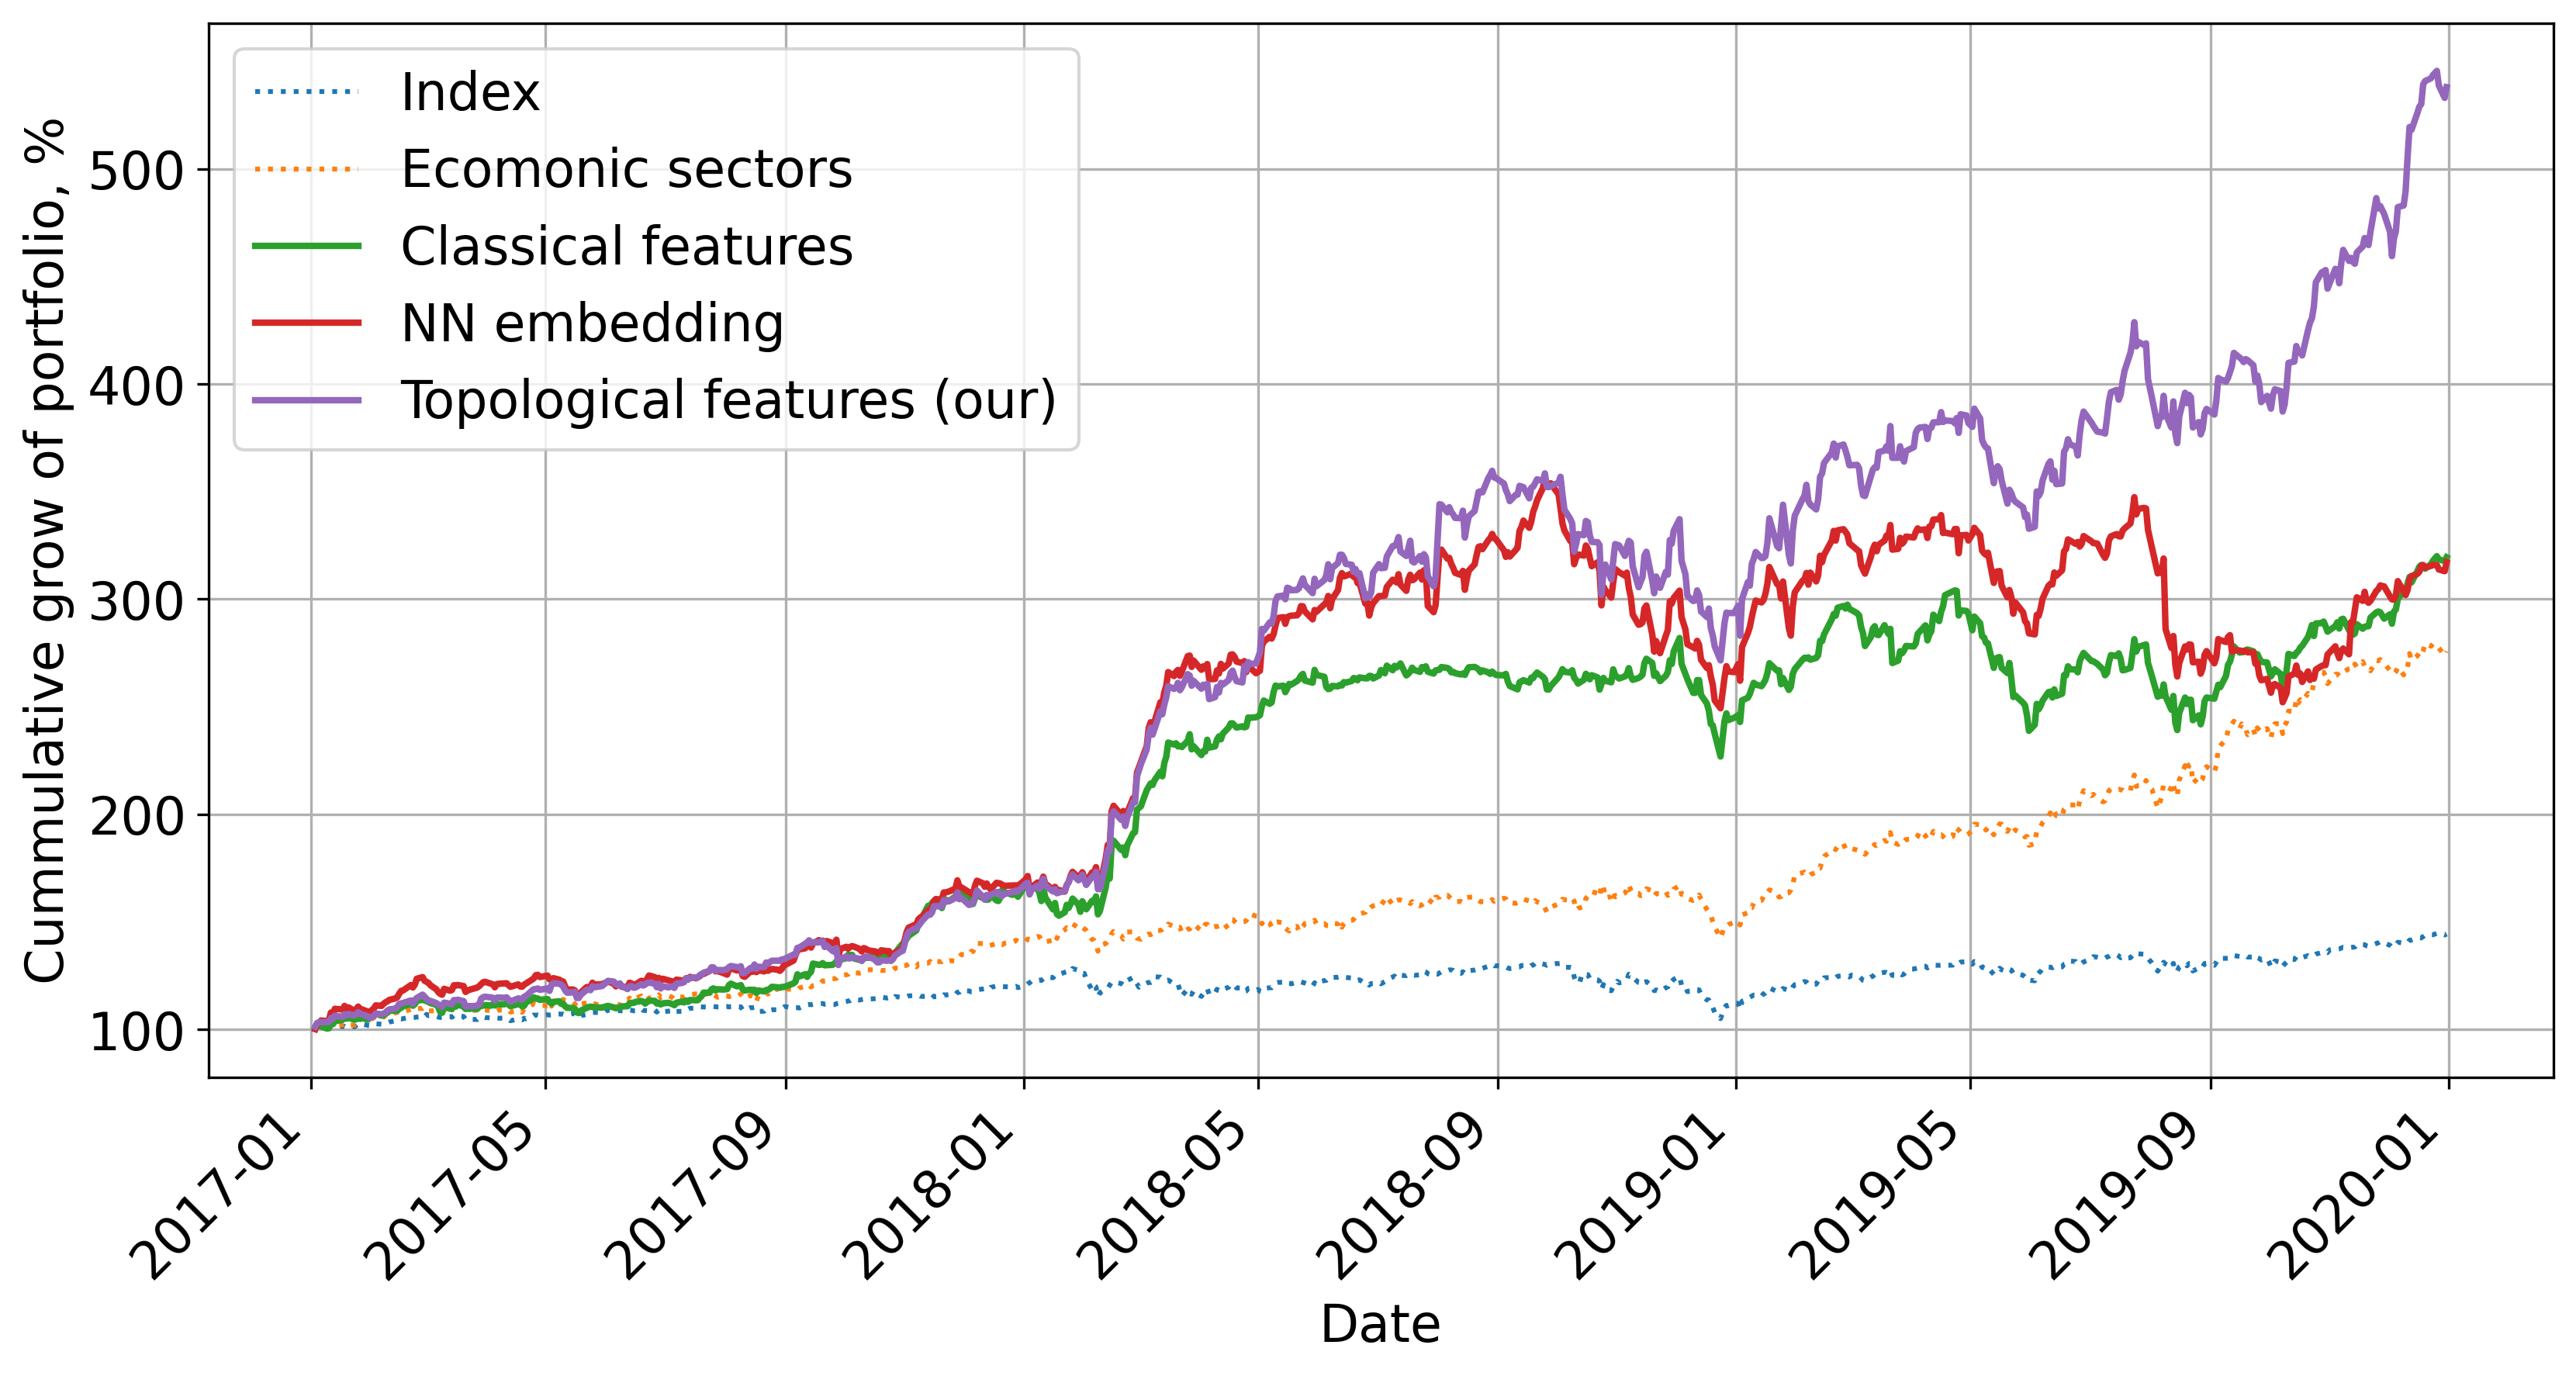

In [24]:
fs = 16

plt.figure(figsize=(13, 6), dpi=300)

for method_name in methods_to_save:
    vals = methods[method_name]
    new_label = method_name[0].upper() + method_name[1:]
    
    if 'opolog' in new_label:
        new_label = new_label + ' (our)'
    plt.plot((1+ vals).cumprod() * 100, label=new_label, **method_styles[method_name])

plt.xticks(rotation=45, ha='right', fontsize=fs)
plt.yticks(fontsize=fs)
plt.grid()
plt.legend(fontsize=fs)
plt.xlabel('Date', fontsize=fs)
plt.ylabel('Cummulative grow of portfolio, %', fontsize=fs)

plt.show()